In [73]:
import geemap, ee, datetime as dt
import pandas as pd
import requests, time
import numpy as np

import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import tensorflow as tf
from glob import glob

In [74]:
import geopandas as gpd
from shapely.geometry import Point

In [75]:
ee.Initialize(project='stat-288-final-project-458620')

In [76]:
# MODIS land aerosol optical depth, daily 1 km
AOD = ee.ImageCollection("MODIS/061/MCD19A2_GRANULES")

# MODIS 16-day NDVI, 16-day 1 km
NDVI = ee.ImageCollection("MODIS/MCD43A4_006_NDVI")

# VIIRS night-time lights, daily 1 km
VNTL = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')

BANDS_CORE = ['Optical_Depth_047', 'AOD_QA', 'Column_WV', 'NDVI']        # always available
BAND_NTL   = 'avg_rad'   # monthly night‑lights
PATCH  = 32
SCALE  = 1000

In [77]:
# Print the first image's metadata and bands for each collection
def print_first_image_info(collection, name):
    first_img = collection.first()
    info = first_img.getInfo()
    print(f"--- {name} ---")
    print("ID:", info['id'])
    print("Bands:", [band['id'] for band in info['bands']])
    print("Properties:", list(info['properties'].keys()))
    print()

In [78]:
print_first_image_info(AOD, "AOD")
print_first_image_info(NDVI, "NDVI")
print_first_image_info(VNTL, "Night Lights")

--- AOD ---
ID: MODIS/061/MCD19A2_GRANULES/MCD19A2_A2000055_h00v08_061_2022153215218_01
Bands: ['Optical_Depth_047', 'Optical_Depth_055', 'AOD_Uncertainty', 'Column_WV', 'AOD_QA', 'Injection_Height', 'cosSZA', 'cosVZA', 'RelAZ', 'Scattering_Angle', 'Glint_Angle', 'FineModeFraction', 'AngstromExp_470-780']
Properties: ['SATELLITE', 'system:time_end', 'DESCRREVISION', 'system:time_start', 'ALGORITHMPACKAGENAME', 'LOCALVERSIONID', 'PGEVERSION', 'system:footprint', 'PRODUCTIONDATETIME', 'system:asset_size', 'ALGORITHMPACKAGEVERSION', 'system:index']

--- NDVI ---
ID: MODIS/MCD43A4_006_NDVI/2000_02_24
Bands: ['NDVI']
Properties: ['system:time_start', 'system:time_end', 'system:index']

--- Night Lights ---
ID: NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG/20140101
Bands: ['avg_rad', 'cf_cvg']
Properties: ['system:time_start', 'system:footprint', 'system:time_end', 'system:asset_size', 'system:index']



In [79]:
def weekly_image(start):
    """Return a 4‑ or 5‑band image covering start–start+7 days."""
    start = ee.Date(start)
    end   = start.advance(7, 'day')
    
    # 1. MODIS aerosol + NDVI
    aod  = (AOD.filterDate(start, end)
                .select(['Optical_Depth_047', 'AOD_QA', 'Column_WV'])
                .median())
    ndvi = NDVI.filterDate(start, end).select('NDVI').median()
    base = aod.addBands(ndvi)

    # 2. Monthly night‑lights: pick the *calendar month* containing `start`
    ntl_month = VNTL.filterDate(start, start.advance(1, 'month')).first()
    
    img = ee.Image(ee.Algorithms.If(
        ntl_month,
        base.addBands(ntl_month.select(BAND_NTL).rename('NTL')),  # 5 bands
        base                                                     # 4 bands (no NTL)
    )).set({'system:time_start': start.millis()})
    
    return img

In [80]:
# weekly collection, convert to array bands
def weekly_collection(date_from, date_to):
    start = ee.Date(date_from); stop = ee.Date(date_to)
    n_weeks = stop.difference(start, 'week').round()
    imgs = ee.List.sequence(0, n_weeks.subtract(1)).map(
        lambda i: weekly_image(start.advance(i, 'week')))
    return ee.ImageCollection(imgs)

def to_array(img):
    # Convert every band to array version (whatever bands exist)
    return img.neighborhoodToArray(ee.Kernel.square(PATCH//2, 'pixels'))

ic_arrays = weekly_collection('2010-01-01', '2024-12-31').map(to_array)

In [81]:
df_delhi = pd.read_csv('data/delhi_weekly_pm25.csv')
df_lagos = pd.read_csv('data/lagos_weekly_pm25.csv')

In [82]:
# create one point per sensor

def df_to_fc(df, city_tag):
    """
    Convert weekly DataFrame -> one‑point‑per‑sensor FeatureCollection.
    Keeps 'sid' as a property and adds a 'city' tag.
    """
    # 1. Get one row per sensor
    sensors = (df[["sid", "latitude", "longitude"]]
               .drop_duplicates())

    # 2. Build a GeoDataFrame with shapely Points
    gdf = gpd.GeoDataFrame(
        sensors,
        geometry=[Point(xy) for xy in zip(sensors.longitude, sensors.latitude)],
        crs="EPSG:4326"
    )

    # 3. Convert to Earth‑Engine FeatureCollection
    fc = geemap.gdf_to_ee(gdf, geodesic=False)

    # 4. Add a 'city' property to every feature
    fc = fc.map(lambda f: f.set({"city": city_tag}))

    return fc

fc_delhi = df_to_fc(df_delhi, "delhi")
fc_lagos = df_to_fc(df_lagos, "lagos")
print("Delhi sensors:", fc_delhi.size().getInfo())
print("Lagos sensors:", fc_lagos.size().getInfo())

Delhi sensors: 46
Lagos sensors: 1


In [83]:
PATCH  = 32                              # pixels (≈ 32 km @ 1‑km MODIS)
SCALE  = 1000                            # meters
kernel = ee.Kernel.square(PATCH // 2, "pixels")

In [84]:
def weekly_samples(img, fc_points):
    return img.sampleRegions(
        collection   = fc_points,
        scale        = SCALE,
        tileScale    = 4,
        geometries   = True
    ).map(lambda f: f.set('week_ms', img.date().millis()))

In [85]:
samples_delhi = ic_arrays.map(lambda img: weekly_samples(img, fc_delhi)).flatten()
samples_lagos = ic_arrays.map(lambda img: weekly_samples(img, fc_lagos)).flatten()

In [86]:
# ee.batch.Export.table.toDrive(
#     samples_delhi,
#     description='delhi_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

# ee.batch.Export.table.toDrive(
#     samples_lagos,
#     description='lagos_patches32',
#     fileFormat='TFRecord',
#     selectors=None  # export all properties
# ).start()

In [87]:
# Path to your TFRecord file (update as needed)
filename = "data/delhi_patches32.tfrecord"

# Read the TFRecord file
raw_dataset = tf.data.TFRecordDataset(filename)

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    for k, v in example.features.feature.items():
        print(f"{k}: {v.WhichOneof('kind')}")

system:index: bytes_list
Optical_Depth_047: float_list
longitude: float_list
week_ms: float_list
latitude: float_list
sid: float_list
AOD_QA: float_list
city: bytes_list
NDVI: float_list
Column_WV: float_list


In [88]:
# Load the CSV file
delhi_pm25_df = pd.read_csv('data/delhi_weekly_pm25.csv')

# Display the first few rows to understand the structure
print("Delhi Weekly PM2.5 Data Structure:")
print(delhi_pm25_df.head())

# Display basic information about the dataframe
print("\nDataframe Info:")
print(f"Shape: {delhi_pm25_df.shape}")
print(f"Columns: {delhi_pm25_df.columns.tolist()}")

# Display summary statistics
print("\nSummary Statistics:")
print(delhi_pm25_df.describe())

Delhi Weekly PM2.5 Data Structure:
   sid        week  location_id   latitude  longitude   pm25_mean  \
0   35  2017-12-26           17  28.563262  77.186937  259.000000   
1   35  2018-01-02           17  28.563262  77.186937  214.000000   
2   35  2018-01-09           17  28.563262  77.186937  194.142857   
3   35  2018-01-16           17  28.563262  77.186937  266.333333   
4   35  2018-01-23           17  28.563262  77.186937  181.800000   

   pm25_median  pm25_min  pm25_max parameter_name parameter_units  \
0        259.0     259.0     259.0           pm25           µg/m³   
1        225.0     159.0     257.0           pm25           µg/m³   
2        197.0     157.0     267.0           pm25           µg/m³   
3        262.0     233.0     314.0           pm25           µg/m³   
4        184.0     127.0     228.0           pm25           µg/m³   

   measurements  
0             1  
1             7  
2             7  
3             6  
4             5  

Dataframe Info:
Shape: (29

In [89]:
import tensorflow as tf

filename = "data/delhi_patches32.tfrecord"  # update as needed
raw_dataset = tf.data.TFRecordDataset(filename)
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "week_ms"
    value {
      float_list {
        value: 1.26230397e+12
      }
    }
  }
  feature {
    key: "system:index"
    value {
      bytes_list {
        value: "0_28_0"
      }
    }
  }
  feature {
    key: "sid"
    value {
      float_list {
        value: 15570
      }
    }
  }
  feature {
    key: "longitude"
    value {
      float_list {
        value: 76.8023834
      }
    }
  }
  feature {
    key: "latitude"
    value {
      float_list {
        value: 28.5206833
      }
    }
  }
  feature {
    key: "city"
    value {
      bytes_list {
        value: "delhi"
      }
    }
  }
  feature {
    key: "Optical_Depth_047"
    value {
      float_list {
        value: 500
        value: 492
        value: 489
        value: 498
        value: 503
        value: 505
        value: 506
        value: 490
        value: 495
        value: 502
        value: 505.5
        value: 511
        value: 523
        value: 538
        value: 543

Record metadata:
Week: 2024-12-26 (timestamp: 1735257620480.0)
Sensor ID: 19900.0
Location: (28.61128044128418, 77.23773956298828)


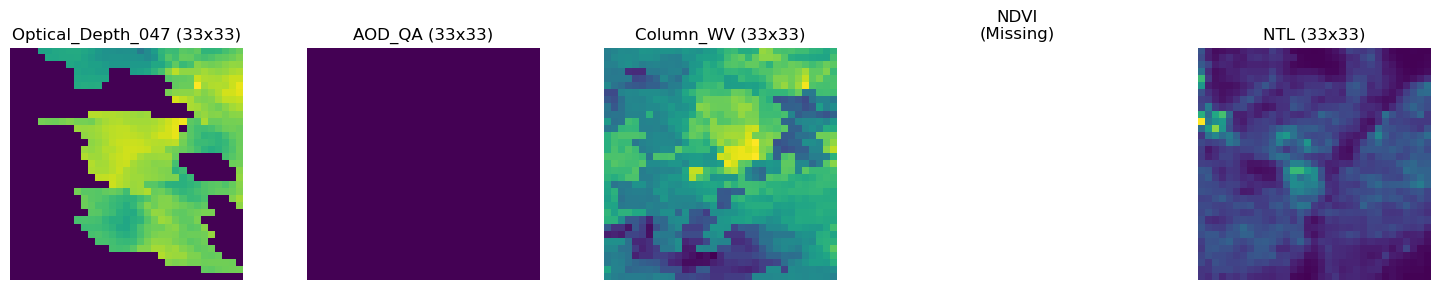

In [90]:
# Read the last record
raw_dataset = tf.data.TFRecordDataset(filename)
# Convert to list to get the last record
records_list = list(raw_dataset)
raw_record = records_list[-1] if records_list else None
example = tf.train.Example()
if raw_record:
    example.ParseFromString(raw_record.numpy())

# Print metadata about the record
print("Record metadata:")
if 'week_ms' in example.features.feature:
    week_ms = example.features.feature['week_ms'].float_list.value[0]
    week_date = dt.datetime.fromtimestamp(week_ms/1000).strftime('%Y-%m-%d')
    print(f"Week: {week_date} (timestamp: {week_ms})")
else:
    print("Week timestamp not found")

if 'sid' in example.features.feature:
    sid = example.features.feature['sid'].float_list.value[0]
    print(f"Sensor ID: {sid}")
else:
    print("Sensor ID not found")

if 'latitude' in example.features.feature and 'longitude' in example.features.feature:
    lat = example.features.feature['latitude'].float_list.value[0]
    lon = example.features.feature['longitude'].float_list.value[0]
    print(f"Location: ({lat}, {lon})")
else:
    print("Location coordinates not found")

# List the bands you want to visualize
bands = ['Optical_Depth_047', 'AOD_QA', 'Column_WV', 'NDVI', 'NTL']  # adjust as needed

# Extract and plot each band
fig, axs = plt.subplots(1, len(bands), figsize=(15, 3))
for i, band in enumerate(bands):
    feature = example.features.feature.get(band)
    if feature is None:
        axs[i].set_title(f"{band}\n(Missing)")
        axs[i].axis('off')
        continue
    
    # Try float_list first, then bytes_list
    if feature.float_list.value:
        # Calculate the actual dimensions - sqrt of the array size
        arr_size = len(feature.float_list.value)
        dim = int(np.sqrt(arr_size))
        if dim * dim != arr_size:
            print(f"Warning: {band} has {arr_size} elements, not a perfect square")
            axs[i].set_title(f"{band}\n(Size: {arr_size})")
            axs[i].axis('off')
            continue
        arr = np.array(feature.float_list.value).reshape(dim, dim)
    elif feature.bytes_list.value:
        # For bytes, also calculate dimensions dynamically
        arr = np.frombuffer(feature.bytes_list.value[0], dtype=np.uint16)
        arr_size = len(arr)
        dim = int(np.sqrt(arr_size))
        if dim * dim != arr_size:
            print(f"Warning: {band} has {arr_size} elements, not a perfect square")
            axs[i].set_title(f"{band}\n(Size: {arr_size})")
            axs[i].axis('off')
            continue
        arr = arr.reshape(dim, dim).astype(np.float32)
    else:
        axs[i].set_title(f"{band}\n(Unknown type)")
        axs[i].axis('off')
        continue
    
    axs[i].imshow(arr, cmap='viridis')
    axs[i].set_title(f"{band} ({dim}x{dim})")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### CNN Training and Transfer

In [91]:
df_delhi.head()

,sid,week,location_id,latitude,longitude,pm25_mean,pm25_median,pm25_min,pm25_max,parameter_name,parameter_units,measurements
0,35,2017-12-26,17,28.563262,77.186937,259.000000,259.0,259.0,259.0,pm25,µg/m³,1
1,35,2018-01-02,17,28.563262,77.186937,214.000000,225.0,159.0,257.0,pm25,µg/m³,7
2,35,2018-01-09,17,28.563262,77.186937,194.142857,197.0,157.0,267.0,pm25,µg/m³,7
3,35,2018-01-16,17,28.563262,77.186937,266.333333,262.0,233.0,314.0,pm25,µg/m³,6
4,35,2018-01-23,17,28.563262,77.186937,181.800000,184.0,127.0,228.0,pm25,µg/m³,5


In [92]:
def load_tfrecord_data(tfrecord_path):
    """
    Load TFRecord data from the given path. Expects TFRecords with features:
      - 'sid': Sensor ID (float)
      - 'week_ms': Week start timestamp in milliseconds (float)
      - 'Optical_Depth_047': AOD values (float_list)
      - 'AOD_QA': Quality assurance values (float_list)
      - 'NDVI': Normalized Difference Vegetation Index values (float_list)
      - 'Column_WV': Column water vapor values (float_list)
      - 'longitude', 'latitude': Coordinates (float)
      - 'city': City name (bytes)
    Returns:
      A pandas DataFrame with columns ['sid', 'week_ms', 'patch'].
      'sid' is int, 'week_ms' is int, and 'patch' is a numpy array of shape (32, 32, 4)
      where the 4 channels are [Optical_Depth_047, AOD_QA, NDVI, Column_WV].
    """
    PATCH = 33
    bands = ['Optical_Depth_047', 'AOD_QA', 'NDVI', 'Column_WV']
    data = []
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP")
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        features = example.features.feature
        
        # Extract sensor ID
        sid = int(features['sid'].float_list.value[0])
        
        # Extract week timestamp (ms since epoch)
        week_ms = int(features['week_ms'].float_list.value[0])
        
        # Extract coordinates
        longitude = features['longitude'].float_list.value[0]
        latitude = features['latitude'].float_list.value[0]
        
        # Extract the four bands to create the patch
        patch = []
        for band in bands:
            arr = features[band].float_list.value
            if len(arr) == PATCH * PATCH:
                arr = np.array(arr).reshape(PATCH, PATCH)
            else:
                arr = np.zeros((PATCH, PATCH), dtype=np.float32)
            patch.append(arr)
        patch = np.stack(patch, axis=-1)
        
        # Append to list
        data.append({
            'sid': sid, 
            'week_ms': week_ms, 
            'longitude': longitude,
            'latitude': latitude,
            'patch': patch
        })
        
        # Optional: extract city if needed
        if 'city' in features:
            data[-1]['city'] = features['city'].bytes_list.value[0].decode('utf-8')
            
    return pd.DataFrame(data)

In [93]:
def load_csv_data(csv_path):
    """
    Load the OpenAQ weekly PM2.5 CSV from the given path.
    Returns:
      A pandas DataFrame with columns ['sid', 'week', 'pm25_mean', 'year', 'week_ms'].
      - 'sid' is int
      - 'week' is the week start date string (YYYY-MM-DD)
      - 'pm25_mean' is float
      - 'year' is int (year of the week)
      - 'week_ms' is int (timestamp in ms for the week start)
    """
    df = pd.read_csv(csv_path)
    # Ensure correct dtypes
    if 'sid' in df.columns:
        df['sid'] = df['sid'].astype(int)
    if 'pm25_mean' in df.columns:
        df['pm25_mean'] = df['pm25_mean'].astype(float)
    # Parse week dates to datetime and extract year and timestamp
    if 'week' in df.columns:
        df['date'] = pd.to_datetime(df['week'])
    else:
        # If no 'week' column (unlikely in our case), try 'week_ms'
        if 'week_ms' in df.columns:
            df['date'] = pd.to_datetime(df['week_ms'], unit='ms')
        else:
            raise ValueError("CSV must contain 'week' or 'week_ms' column for dates.")
    df['year'] = df['date'].dt.year
    # Convert week start to milliseconds timestamp (epoch)
    # Use floor division by 1e6 because pandas datetime is in ns.
    df['week_ms'] = (df['date'].astype(np.int64) // 10**6).astype(np.int64)
    return df[['sid', 'week', 'pm25_mean', 'year', 'week_ms']]

In [95]:
def build_cnn_model(input_shape):
    """
    Build and compile a small CNN model for regression on image patches.
    input_shape: tuple, e.g. (32, 32, 1) or (32, 32, 3).
    Returns:
      A compiled tf.keras.Model ready for training.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)  # output layer for PM2.5
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse', metrics=['mae'])
    return model


In [96]:
def train_model_on_delhi(model, X_train, y_train, X_val, y_val):
    """
    Train the CNN model on Delhi training data and evaluate on validation data.
    Logs RMSE and MAE for the validation (Delhi 2023).
    Returns the trained model.
    """
    # Train the model on Delhi data
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=2)
    # Predict on validation set
    y_pred_val = model.predict(X_val).reshape(-1)
    y_true_val = y_val.reshape(-1)
    rmse_val = np.sqrt(np.mean((y_pred_val - y_true_val) ** 2))
    mae_val = np.mean(np.abs(y_pred_val - y_true_val))
    print(f"Delhi 2023 Validation – RMSE: {rmse_val:.2f}, MAE: {mae_val:.2f}")
    return model

In [97]:
def fine_tune_on_lagos(model, X_train, y_train, baseline_model=None):
    """
    Fine-tune the model on Lagos data.
    If the Lagos training set is small (< 100 samples), perform linear regression correction (y_adj = α + β * y_pred).
    If larger, freeze early conv layers and fine-tune the dense head with a low learning rate.
    Params:
      model: Trained source model (after Delhi training).
      X_train, y_train: Lagos training data (patches and labels).
      baseline_model: (Optional) original model to use for predictions in linear mode if model gets modified.
    Returns:
      If linear correction is used, returns (alpha, beta) coefficients.
      If fine-tuning is done, returns the fine-tuned model.
    """
    n = X_train.shape[0]
    if n < 100:
        # Linear calibration approach
        if baseline_model is None:
            baseline_model = model
        # Get predictions from the baseline (Delhi-trained) model
        y_pred = baseline_model.predict(X_train).reshape(-1)
        y_true = y_train.reshape(-1)
        # Fit linear least squares: y_true = alpha + beta * y_pred
        A = np.vstack([np.ones(n), y_pred]).T
        # Solve for [alpha, beta]
        coeffs, _, _, _ = np.linalg.lstsq(A, y_true, rcond=None)
        alpha, beta = coeffs[0], coeffs[1]
        print(f"Lagos calibration: alpha = {alpha:.3f}, beta = {beta:.3f}")
        return (alpha, beta)
    else:
        # Fine-tune CNN on Lagos
        # Freeze convolutional layers to retain Delhi features
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer.trainable = False
        # Recompile with a smaller learning rate for fine-tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        # Fine-tune on Lagos data with higher sample weight
        sample_weight = np.ones(n) * 5.0
        model.fit(X_train, y_train, epochs=20, batch_size=8, sample_weight=sample_weight, verbose=2)
        return model

In [98]:
def evaluate_on_lagos(model, X_test, y_test, adaptation=None):
    """
    Evaluate the model (and optionally an adapted version) on Lagos test data.
    If adaptation is a tuple (alpha, beta), use linear calibration on the model's predictions.
    If adaptation is a model (fine-tuned), use it directly for predictions.
    Prints out RMSE and R^2 for zero-shot vs fine-tuned, and AUROC for WHO threshold exceedance.
    """
    # Ground truth
    y_true = y_test.reshape(-1)
    # Baseline (zero-shot) predictions using original model
    y_pred_base = model.predict(X_test).reshape(-1)
    # If adaptation provided, get adapted predictions
    if adaptation is None:
        # No adaptation, use baseline only
        y_pred_adapt = None
    elif isinstance(adaptation, tuple):
        # Linear calibration: adaptation = (alpha, beta)
        alpha, beta = adaptation
        y_pred_adapt = alpha + beta * y_pred_base
    else:
        # Adaptation is a fine-tuned model
        y_pred_adapt = adaptation.predict(X_test).reshape(-1)
    # Compute metrics for baseline
    rmse_base = np.sqrt(np.mean((y_pred_base - y_true) ** 2))
    mae_base = np.mean(np.abs(y_pred_base - y_true))
    # R^2 (coefficient of determination) for baseline
    ss_res_base = np.sum((y_true - y_pred_base) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2_base = 1 - ss_res_base/ss_tot if ss_tot != 0 else 0.0
    print(f"Lagos 2023 (Zero-shot) – RMSE: {rmse_base:.2f}, MAE: {mae_base:.2f}, R^2: {r2_base:.3f}")
    if y_pred_adapt is not None:
        # Compute metrics for adapted model
        rmse_adapt = np.sqrt(np.mean((y_pred_adapt - y_true) ** 2))
        mae_adapt = np.mean(np.abs(y_pred_adapt - y_true))
        ss_res_adapt = np.sum((y_true - y_pred_adapt) ** 2)
        r2_adapt = 1 - ss_res_adapt/ss_tot if ss_tot != 0 else 0.0
        print(f"Lagos 2023 (Fine-tuned) – RMSE: {rmse_adapt:.2f}, MAE: {mae_adapt:.2f}, R^2: {r2_adapt:.3f}")
    # WHO 15 µg/m³ exceedance classification
    # Create binary labels for exceedance (1 if >=15, 0 if below 15)
    threshold = 15.0  # µg/m³ WHO guideline threshold
    y_true_exceed = (y_true >= threshold).astype(int)
    
    # Check if we have both classes (0 and 1) in y_true_exceed before calculating AUROC
    unique_classes = np.unique(y_true_exceed)
    if len(unique_classes) > 1:
        # Calculate AUROC for baseline predictions
        auc_base = roc_auc_score(y_true_exceed, y_pred_base)
        if y_pred_adapt is not None:
            auc_adapt = roc_auc_score(y_true_exceed, y_pred_adapt)
            print(f"Lagos 2023 – WHO 15 µg/m³ exceedance AUROC: baseline = {auc_base:.3f}, fine-tuned = {auc_adapt:.3f}")
        else:
            print(f"Lagos 2023 – WHO 15 µg/m³ exceedance AUROC: baseline = {auc_base:.3f}")
    else:
        # Handle the case where all values are the same class
        class_value = unique_classes[0]
        print(f"Lagos 2023 – All PM2.5 values are {'above' if class_value == 1 else 'below'} the WHO 15 µg/m³ threshold. AUROC not defined.")

In [99]:
# File paths
delhi_tf_path = "data/delhi_patches32.tfrecord.gz"
lagos_tf_path = "data/lagos_patches32.tfrecord.gz"
delhi_csv_path = "data/delhi_weekly_pm25.csv"
lagos_csv_path = "data/lagos_weekly_pm25.csv"
# Load TFRecord and CSV data
print("Loading Delhi TFRecord data...")
delhi_patches = load_tfrecord_data(delhi_tf_path)
print(f"Loaded {len(delhi_patches)} Delhi patch samples.")
print("Loading Lagos TFRecord data...")
lagos_patches = load_tfrecord_data(lagos_tf_path)
print(f"Loaded {len(lagos_patches)} Lagos patch samples.")
print("Loading Delhi labels CSV...")
delhi_labels = load_csv_data(delhi_csv_path)
print(f"Loaded {len(delhi_labels)} Delhi label entries.")
print("Loading Lagos labels CSV...")
lagos_labels = load_csv_data(lagos_csv_path)
print(f"Loaded {len(lagos_labels)} Lagos label entries.")

Loading Delhi TFRecord data...
Loaded 20983 Delhi patch samples.
Loading Lagos TFRecord data...
Loaded 172 Lagos patch samples.
Loading Delhi labels CSV...
Loaded 2948 Delhi label entries.
Loading Lagos labels CSV...
Loaded 50 Lagos label entries.


In [100]:
delhi_patches

,sid,week_ms,longitude,latitude,patch,city
0,15570,1262303969280,76.802383,28.520683,"[[[500.0, 1283.0, 0.6751269102096558, 856.5], ...",delhi
1,17564,1262303969280,76.849693,28.422886,"[[[472.5, 1283.0, 0.6628372669219971, 916.0], ...",delhi
2,35,1264118398976,77.186935,28.563263,"[[[912.0, 1283.0, 0.165178582072258, 1092.0], ...",delhi
3,388,1264118398976,77.200500,28.634100,"[[[872.5, 1283.0, 0.3441396653652191, 1064.5],...",delhi
4,1166,1264118398976,77.026306,28.450125,"[[[702.0, 1283.0, 0.5390138030052185, 1234.5],...",delhi
...,...,...,...,...,...,...
20978,15629,1735257620480,77.284622,28.631050,"[[[0.0, 1283.0, 0.0, 849.0], [0.0, 1283.0, 0.0...",delhi
20979,17564,1735257620480,76.849693,28.422886,"[[[0.0, 1283.0, 0.0, 965.0], [0.0, 1283.0, 0.0...",delhi
20980,17790,1735257620480,77.302521,28.681173,"[[[0.0, 1283.0, 0.0, 987.0], [0.0, 1283.0, 0.0...",delhi
20981,19884,1735257620480,77.358078,28.646233,"[[[929.0, 1283.0, 0.0, 1025.5], [0.0, 1283.0, ...",delhi


In [101]:
# For Delhi patches
delhi_patches['week'] = pd.to_datetime(delhi_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')

# For Lagos patches
lagos_patches['week'] = pd.to_datetime(lagos_patches['week_ms'], unit='ms').dt.strftime('%Y-%m-%d')

In [103]:
# For patches
for df in [delhi_patches, lagos_patches]:
    df['week_dt'] = pd.to_datetime(df['week_ms'], unit='ms')
    df['iso_year'] = df['week_dt'].dt.isocalendar().year
    df['iso_week'] = df['week_dt'].dt.isocalendar().week

# For labels
for df in [delhi_labels, lagos_labels]:
    df['week_dt'] = pd.to_datetime(df['week'], errors='coerce')
    df['iso_year'] = df['week_dt'].dt.isocalendar().year
    df['iso_week'] = df['week_dt'].dt.isocalendar().week

In [104]:
# For Delhi
delhi_merged = pd.merge(
    delhi_patches, delhi_labels,
    on=['sid', 'iso_year', 'iso_week'],
    how='inner'
)

# For Lagos
lagos_merged = pd.merge(
    lagos_patches, lagos_labels,
    on=['sid', 'iso_year', 'iso_week'],
    how='inner'
)

In [107]:
delhi_merged

,sid,week_ms_x,longitude,latitude,patch,city,week_x,week_dt_x,iso_year,iso_week,week_y,pm25_mean,year,week_ms_y,week_dt_y
0,35,1514505633792,77.186935,28.563263,"[[[994.0, 1057.0, 0.2504837214946747, 898.5], ...",delhi,2017-12-29,2017-12-29 00:00:33.792,2017,52,2017-12-26,259.000000,2017,1514246400000,2017-12-26
1,388,1514505633792,77.200500,28.634100,"[[[931.5, 1280.0, 0.3203197419643402, 886.0], ...",delhi,2017-12-29,2017-12-29 00:00:33.792,2017,52,2017-12-26,377.000000,2017,1514246400000,2017-12-26
2,13860,1514505633792,77.158096,28.651699,"[[[902.5, 1280.0, 0.0, 886.5], [959.0, 1280.0,...",delhi,2017-12-29,2017-12-29 00:00:33.792,2017,52,2017-12-26,349.000000,2017,1514246400000,2017-12-26
3,13861,1514505633792,77.249397,28.623501,"[[[904.0, 1280.0, 0.0, 905.0], [955.5, 1089.0,...",delhi,2017-12-29,2017-12-29 00:00:33.792,2017,52,2017-12-26,235.500000,2017,1514246400000,2017-12-26
4,13900,1514505633792,77.313774,28.410122,"[[[1108.0, 1280.0, 0.5578562617301941, 1098.0]...",delhi,2017-12-29,2017-12-29 00:00:33.792,2017,52,2017-12-26,260.000000,2017,1514246400000,2017-12-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,14985,1665705574400,77.111259,28.750050,"[[[497.0, 1.0, 0.0, 1751.0], [496.0, 1.0, 0.0,...",delhi,2022-10-13,2022-10-13 23:59:34.400,2022,41,2022-10-11,57.116667,2022,1665446400000,2022-10-11
1382,17770,1665705574400,77.201065,28.636429,"[[[410.0, 1281.0, 0.5860679745674133, 1840.0],...",delhi,2022-10-13,2022-10-13 23:59:34.400,2022,41,2022-10-11,39.850000,2022,1665446400000,2022-10-11
1383,17776,1665705574400,77.131020,28.674046,"[[[520.0, 433.0, 0.4561298191547394, 1909.0], ...",delhi,2022-10-13,2022-10-13 23:59:34.400,2022,41,2022-10-11,84.680000,2022,1665446400000,2022-10-11
1384,19900,1665705574400,77.237740,28.611280,"[[[469.0, 1282.0, 0.0, 1887.0], [488.0, 1282.0...",delhi,2022-10-13,2022-10-13 23:59:34.400,2022,41,2022-10-11,71.950000,2022,1665446400000,2022-10-11


In [126]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [110]:
# Split the data into training and test sets by random sampling (not by time)
# For Delhi: 80% training, 20% test
delhi_train, delhi_test = train_test_split(delhi_merged, test_size=0.2, random_state=42)

# For Lagos: 80% training, 20% test
lagos_train, lagos_test = train_test_split(lagos_merged, test_size=0.2, random_state=42)

# Print the shapes to verify the split
print(f"Delhi data: {len(delhi_merged)} total samples")
print(f"Delhi training: {len(delhi_train)} samples, Delhi test: {len(delhi_test)} samples")
print(f"Lagos data: {len(lagos_merged)} total samples")
print(f"Lagos training: {len(lagos_train)} samples, Lagos test: {len(lagos_test)} samples")

# Verify that the splits are random across time (not time-based)
print("\nDistribution of years in Delhi training set:")
print(delhi_train['year'].value_counts().sort_index())
print("\nDistribution of years in Delhi test set:")
print(delhi_test['year'].value_counts().sort_index())


Delhi data: 1386 total samples
Delhi training: 1108 samples, Delhi test: 278 samples
Lagos data: 13 total samples
Lagos training: 10 samples, Lagos test: 3 samples

Distribution of years in Delhi training set:
year
2017      5
2018    261
2019     83
2020    358
2021    252
2022    149
Name: count, dtype: int64

Distribution of years in Delhi test set:
year
2018    62
2019    22
2020    85
2021    70
2022    39
Name: count, dtype: int64


In [111]:
sample_patch = delhi_train['patch'].iloc[0]
input_shape = sample_patch.shape  # e.g., (32, 32, 1) or (32, 32, 3)
# Stack patches into numpy arrays
X_delhi_train = np.stack(delhi_train['patch'].values)
y_delhi_train = delhi_train['pm25_mean'].values.astype(np.float32)
X_delhi_val = np.stack(delhi_test['patch'].values) if len(delhi_test) > 0 else np.array([]).reshape(0, *input_shape)
y_delhi_val = delhi_test['pm25_mean'].values.astype(np.float32) if len(delhi_test) > 0 else np.array([], dtype=np.float32)
X_lagos_train = np.stack(lagos_train['patch'].values) if len(lagos_train) > 0 else np.array([]).reshape(0, *input_shape)
y_lagos_train = lagos_train['pm25_mean'].values.astype(np.float32) if len(lagos_train) > 0 else np.array([], dtype=np.float32)
X_lagos_test = np.stack(lagos_test['patch'].values) if len(lagos_test) > 0 else np.array([]).reshape(0, *input_shape)
y_lagos_test = lagos_test['pm25_mean'].values.astype(np.float32) if len(lagos_test) > 0 else np.array([], dtype=np.float32)

In [114]:
 # Build and train model on Delhi
print("Building CNN model...")
model = build_cnn_model(input_shape)
print("Training model on Delhi data (2018-2022)...")
model = train_model_on_delhi(model, X_delhi_train, y_delhi_train, X_delhi_val, y_delhi_val)
# Save the baseline model (for potential use in linear calibration)
baseline_model = model  # in this script, model is already the baseline after training

Building CNN model...


/opt/miniconda3/envs/t4sg/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model on Delhi data (2018-2022)...
Epoch 1/20
35/35 - 1s - 28ms/step - loss: 34395.4766 - mae: 113.2544 - val_loss: 2708.8723 - val_mae: 38.7004
Epoch 2/20
35/35 - 0s - 5ms/step - loss: 3436.2656 - mae: 43.5161 - val_loss: 3021.7612 - val_mae: 43.5128
Epoch 3/20
35/35 - 0s - 5ms/step - loss: 2860.8762 - mae: 39.9313 - val_loss: 2247.3198 - val_mae: 35.2881
Epoch 4/20
35/35 - 0s - 5ms/step - loss: 2618.5076 - mae: 37.8432 - val_loss: 2238.1636 - val_mae: 35.9788
Epoch 5/20
35/35 - 0s - 5ms/step - loss: 2510.7166 - mae: 37.0104 - val_loss: 2702.3054 - val_mae: 41.7080
Epoch 6/20
35/35 - 0s - 6ms/step - loss: 2259.8796 - mae: 34.9407 - val_loss: 2377.0171 - val_mae: 37.3195
Epoch 7/20
35/35 - 0s - 5ms/step - loss: 2174.1262 - mae: 35.1096 - val_loss: 2193.7969 - val_mae: 35.7602
Epoch 8/20
35/35 - 0s - 5ms/step - loss: 2033.5197 - mae: 33.1257 - val_loss: 2208.9348 - val_mae: 35.8906
Epoch 9/20
35/35 - 0s - 6ms/step - loss: 1977.0007 - mae: 32.6329 - val_loss: 2526.2776 - val_mae

In [131]:
# Save the model locally
print("Saving model to disk...")
model_save_path = 'models/delhi_pm25_cnn_model_v1.keras'  
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Saving model to disk...
Model saved to models/delhi_pm25_cnn_model_v1.keras


In [115]:
# Transfer learning to Lagos
adaptation = None
if len(X_lagos_train) > 0:
    # If we have separate Lagos training data (outside 2023)
    print("Adapting model to Lagos...")
    adaptation = fine_tune_on_lagos(model, X_lagos_train, y_lagos_train, baseline_model=baseline_model)
    # If fine_tune_on_lagos returns a tuple, it means linear coefficients
    if isinstance(adaptation, tuple):
        # In linear case, baseline_model remains unchanged; we use coefficients separately
        model_adapted = None
    else:
        # If returned a model (fine-tuned), that's our adapted model
        model_adapted = adaptation
else:
    # No separate Lagos train set (all Lagos data is 2023), use the data itself for calibration if small
    if len(X_lagos_test) > 0:
        print("Lagos has <100 samples and no separate training set; performing linear calibration on 2023 data...")
        adaptation = fine_tune_on_lagos(model, X_lagos_test, y_lagos_test, baseline_model=baseline_model)
        model_adapted = None
    else:
        model_adapted = None

Adapting model to Lagos...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Lagos calibration: alpha = 12.162, beta = 0.035



Evaluating on Lagos 2023 data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Lagos 2023 Test Metrics:
MAE: 1108.49
MSE: 1349735.23
RMSE: 1161.78
R²: -483954.0849


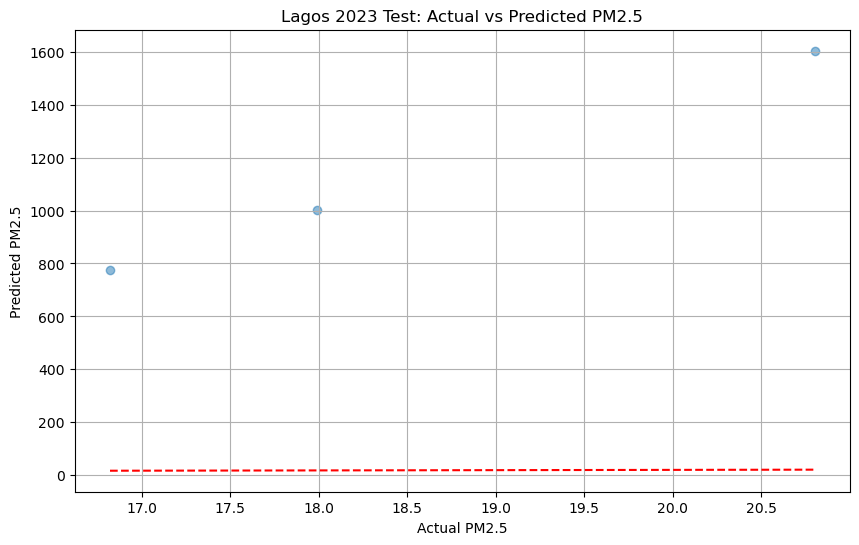

In [128]:
# Evaluate on Lagos 2023
if len(X_lagos_test) > 0:
    print("\nEvaluating on Lagos 2023 data...")
    
    # Determine which model/adaptation to use for prediction
    if isinstance(adaptation, tuple):
        # Linear calibration case
        slope, intercept = adaptation
        base_preds = baseline_model.predict(X_lagos_test)
        y_pred = base_preds * slope + intercept
    elif model_adapted is not None:
        # Fine-tuned model case
        y_pred = model_adapted.predict(X_lagos_test)
    else:
        # No adaptation, use baseline model
        y_pred = baseline_model.predict(X_lagos_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_lagos_test, y_pred)
    mse = mean_squared_error(y_lagos_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_lagos_test, y_pred)
    
    # Print metrics
    print(f"Lagos 2023 Test Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Create a scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_lagos_test, y_pred, alpha=0.5)
    plt.plot([min(y_lagos_test), max(y_lagos_test)], [min(y_lagos_test), max(y_lagos_test)], 'r--')
    plt.xlabel('Actual PM2.5')
    plt.ylabel('Predicted PM2.5')
    plt.title('Lagos 2023 Test: Actual vs Predicted PM2.5')
    plt.grid(True)
    plt.show()
else:
    print("No Lagos 2023 test data available for evaluation.")



Evaluating on Delhi 2023 validation data...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Delhi 2023 Validation Metrics:
MAE: 38.03
MSE: 2493.31
RMSE: 49.93
R²: 0.2908


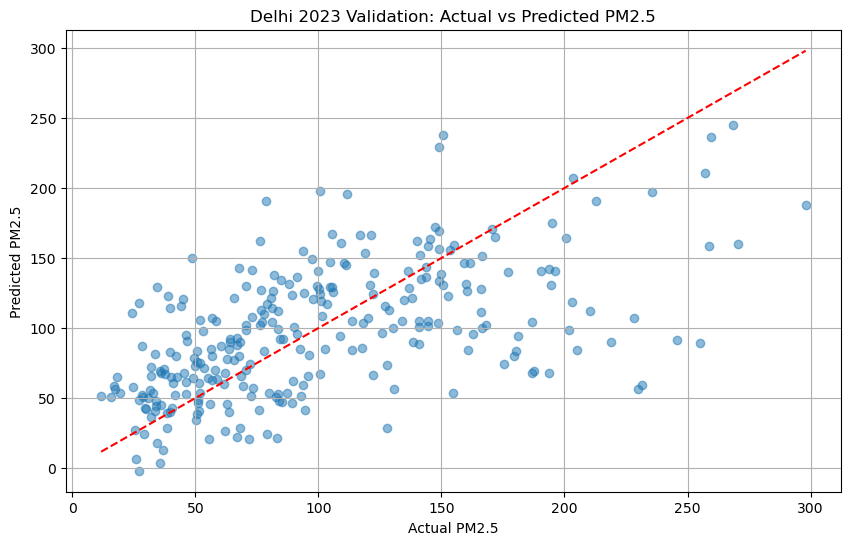

In [127]:
# Evaluate on Delhi 2023 validation set
if len(X_delhi_val) > 0:
    print("\nEvaluating on Delhi 2023 validation data...")
    # Make predictions
    y_pred = model.predict(X_delhi_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_delhi_val, y_pred)
    mse = mean_squared_error(y_delhi_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_delhi_val, y_pred)
    
    # Print metrics
    print(f"Delhi 2023 Validation Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Create a scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_delhi_val, y_pred, alpha=0.5)
    plt.plot([min(y_delhi_val), max(y_delhi_val)], [min(y_delhi_val), max(y_delhi_val)], 'r--')
    plt.xlabel('Actual PM2.5')
    plt.ylabel('Predicted PM2.5')
    plt.title('Delhi 2023 Validation: Actual vs Predicted PM2.5')
    plt.grid(True)
    plt.show()
else:
    print("No Delhi 2023 validation data available for evaluation.")
